 # Lecture7 : MCMC under the Hood 
 
 ## Instructor: Dr. Hu Chuan-Peng 


上节课我们介绍了高级贝叶斯分析中 MCMC 后验模拟的意义和基本原理，以及如何使用 pymc 软件包实现 MCMC 算法。

然而，MCMC 算法中看似随机的采样过程为何会让我们得到后验分布的样本？🤔

我们将在这节课揭露 MCMC 算法背后的秘密。😎

![Image Name](https://cdn.kesci.com/upload/image/rjvix0jc6b.png?imageView2/0/w/320/h/320)

需要注意的是 MCMC 是一种算法思想，在其实现过程中包括众多变种：

- 例如，pymc 默认采用汉密尔顿蒙特卡洛算法 Hamiltonian Monte Carlo（HMC）的改良版 No-U-Turn Sampler（NUTS）。
- 另一些常用的 MCMC 算法包括，吉布斯采样算法 (Gibbs Sampling), 差分进化算法（Differential Evolution, DE）。

虽然细节不同，但这两种算法都是基本 Metropolis-Hastings 算法的变种，并且可以在 pymc 中使用。
    
<table>
        <tr>
            <td><img src="http://gorayni.github.io/assets/posts/gibbs/gibbs2.gif" alt="" width="200" height="200"></td>
            <td><img src="https://matteding.github.io/images/diff_evol.gif" alt="" width="200" height="200"></td>
            <td><img src="https://cdn.kesci.com/upload/image/rjvh3zx4an.gif?imageView2/0/w/640/h/640" alt="" width="200" height="200"></td>
        </tr>
        <tr>
            <td>吉布斯采样算法</td>
            <td>差分进化算法</td>
            <td>汉密尔顿算法</td>
        </tr>
</table>






我们将在本节课重点讨论 Metropolis-Hastings (MH) 算法，而不是研究所有的变种。

- 虽然实现该算法需要计算机编程技能，而这些技能并不在本课程的范围之内（例如编写函数和 for 循环），
- 但我们会将重点放在概念上，以便所有人都能跟上。
- 😜ps. 即使没有学会 MH 算法的实现，也不妨碍我们通过 pymc 来实现各种 MCMC 算法。

🎯Goals
- 从概念上深刻理解马尔科夫链算法的**工作原理**。
- 探索基础 **Metropolis-Hastings** 算法。
- 在**normal-normal**和**beta-binormal**例子中了解 Metropolis-Hastings 算法的运行原理

## Normal-Normal 模型的后验分布

首先，是我们习以为常的 Normal-Normal 模型的例子。


1. **似然模型**：假设我们从一个平均值为$\mu$，标准差为0.75的正态分布中获取了一个Y=6.25的数据：
    $$
    Y|\mu  \sim \ N(\mu, 0.75^2)
    $$

2. **先验模型**：并且，该正态分布群的平均值满足：
    $$
    \mu  \sim \ N(0, 1^2)
    $$

    *可以简单理解成我们一开始对$\mu$的信念，为$\mu$在平均值为0，标准差为1的正态分布中波动*

3. **后验分布**：那么在$Y=6.25$这个结果下，结合先验，更新后的$\mu$是怎样的？

    $$\mu | (Y = 6.25) \sim \text{N}(?,?)$$

> 在lec5中，我们知道Normal-Normal为共轭先验，则后验分布存在可直接计算的方法：

> $$\mu | (Y = 6.25) \sim \text{N}(4, 0.6^2)$$


**🎯目标：使用MCMC来近似 Normal-Normal 模型的后验分布**

之前的课程(lec6)告诉我们，有些时候我们无法直接计算后验分布，但我们可以使用MCMC对后验进行近似。

虽然这里的后验分布可以轻松的计算，但为了能更好地理解 MCMC的原理，我们就从这个简单的例子开始吧 🍻。

假设我们使用MCMC进行了 N=5000次 的采样 (正如在上节课中使用 pymc 做的那样)，那么我们可以得到这样一条马尔科夫链 $\left\lbrace \mu^{(1)}, \mu^{(2)}, \ldots, \mu^{(N)} \right\rbrace$

* 左图展示了每一次采样的结果，而通过右图我们可以知道采样结果的分布如何（即哪些值出现的频率更高）

❓那么这些采样值是怎么得到的？

> 我们以这个Normal-Normal 模型为例，来详细介绍采样的规则

![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch-7-mcmc-goal-1.png)

**1. 后验分布模型 vs. 后验分布采样**

📍需要注意的是，我们现在已经通过公式推导获得了后验分布模型：

$$
\begin{align*}
\mu | (Y = 6.25) & \sim \text{N}(4, 0.6^2) \\
&\propto \exp\left(-\frac{1}{2}\left(\frac{(\mu-\mu_0)^2}{\sigma_0^2} + \frac{(Y-\mu)^2}{\sigma^2}\right)\right) \\
&\propto \exp\left(-\frac{1}{2}\left(\frac{\mu^2 - 2\mu\mu_0 + \mu_0^2}{\sigma_0^2} + \frac{Y^2 - 2Y\mu + \mu^2}{\sigma^2}\right)\right) \\
&\propto \exp\left(-\frac{1}{2}\left(\frac{\mu^2(\frac{1}{\sigma_0^2} + \frac{1}{\sigma^2}) - 2\mu(\frac{\mu_0}{\sigma_0^2} + \frac{Y}{\sigma^2}) + (\frac{\mu_0^2}{\sigma_0^2} + \frac{Y^2}{\sigma^2})}{1}\right)\right) \\
&\propto \exp\left(-\frac{1}{2}\left(\frac{\mu^2 - 2\mu(\frac{\mu_0\sigma^2 + Y\sigma_0^2}{\sigma_0^2\sigma^2}) + (\frac{\mu_0^2\sigma^2 + Y^2\sigma_0^2}{\sigma_0^2\sigma^2})}{1}\right)\right)
\end{align*}
$$

然而，**后验分布模型不等于后验分布采样**
- 换句话说，我们不能直接从上面的后验分布的公式中，得到参数的采样$\left\lbrace \mu^{(1)}, \mu^{(2)}, \ldots, \mu^{(N)} \right\rbrace$。
- 一个类似但不太正规的例子是，
  - 当我们知道线性模型 $f(\mu|Y=6.25, \sigma = 0.75) =  6.25 * \mu + 0.75$，
  - 并且我们想采样很多个 $\mu$，
  - 但$\mu$ 的数量受到 $f(\mu)$的影响，即$f(\mu)$越大时保留的 $\mu$ 的越多，
  - 那么我们如何采样 $\mu$ 呢？

显然，我们无法直接采样得到 $\mu$，**要获得后验分布的采样 $\mu$，我们需要计算后验模型 $f(\mu)$ 的值**。

In [3]:
import plotly.graph_objects as go
import numpy as np
from scipy.stats import norm

In [7]:
x_range = np.linspace(2, 10, 1000)       # 设置 x 的范围为 [0,1]
y_reg = 6.25 * x_range + 0.75            # 设置回归模型
y_norm = norm.pdf(x_range, 6.25, 0.75)

# 使用Plotly绘制回归线
fig = go.Figure()

# 绘制回归线
fig.add_trace(go.Scatter(
    x=x_range,
    y=y_reg,
    mode='lines',
    name='Regression Line'
))

# 绘制正态分布曲线
fig.add_trace(go.Scatter(
    x=x_range,          
    y=y_norm * 100,                      # 扩大 100 倍保持和回归模型的 y 轴单位相似
    mode='lines',
    name='Normal Line'
))


# 设置图表布局
fig.update_layout(
    title='Regression Line and Normal Distribution',
    xaxis_title='X',
    yaxis_title='Y'
)

# 显示图表
fig.show()

**2. 未归一化的后验分布(unnormalized posterior pdf)**

❓但是当分母太过复杂时，我们无法计算后验模型 $f(\mu)$，有什么替代的方法吗？

但通过贝叶斯公式我们知道：

$$f(\mu | y=6.25) \propto f(\mu)L(\mu|y=6.25).$$

- 尽管未归一化的分布并不是真正的后验分布，但这二者的形状、集中趋势、变异性是一样的
- 可以看到，真实的后验分布和未归一化后验分布，处理在 y 轴上的单位不一样，但他们的形状、集中趋势、变异性是一样的
- 重要的是，两个分布中，$\mu$ 的结果主要集中在 2-6 之间

因此，当进行采样时，我们可以使用**未归一化的后验分布** 的结果来替代计算真实的后验分布 $f(\mu)$

![Image Name](https://cdn.kesci.com/upload/s2ty9jty8t.png?imageView2/0/w/960/h/960)


## Metropolis-Hastings(MH)算法

在刚才的例子中，我们已经涉及到 MH 算法最朴素的思想：

- 后验分布模型可以通过公式进行推导得到，然而无法对它进行直接采样。
- 我们可以根据后验模型 y 轴的大小来决定 x 轴参数的数量。 
  - 例如，我们均匀的从参数的范围(x~[0,1])中抽取 10000个参数样本 $\mu_i$。
  - 然后我们计算对于每个 $\mu_i$ 的 $f(\mu_i)$ 的大小，$f(\mu_i)$ 越大那么 $\mu_i$ 被保留的可能性越高。
  - 最后，我们可能保留5000个参数。而此时，这 5000 个参数将不再是
    均匀的分布在[0,1]中，而更接近于后验分布的形状。
- 正如之前提到，计算 $f(\mu_i)$ 是比较困难的，我们可以计算非标准化的 $f(\mu_i)$。
- 此外，直接在[0,1]中均匀的采样效率太低，我们在接下来会利用 MCMC 状态转移的性质来提高采样效率。

现在我们就来体验这个奇妙的过程

### 建议分布(proposed distribution)

为了提高采样效率，我们**不会**直接从一个分布中进行大量采样，再进行筛选(也被称为拒绝)。

在 MCMC 中，我们会构造一个建议分布 (proposed distribution) $q(x)$，然后利用 MCMC 状态转移的性质来进行采样。

<table>  
    <tr>  
        <td><img src="https://pic2.zhimg.com/80/v2-696651b37f2dc6a472c314f1ba78194d_1440w.webp" alt="图片1" width = 600></td>  
    </tr>  
</table>  

首先复习一下MCMC的状态转移的性质：
- 选择每一种英雄对于每一种参数值，也就是每一种状态。
  - 例如，选择百里守约代表 $\theta_1=0.5$; 选择蔡文姬代表 $\theta_2=0.3$；选择赵云代表$\theta_3=0.7$； 以此类推.....。
  - 这样，我们可以确定参数选择的范围 $\theta_{k} \sim [0,1]$，参数是离散变量，每一个值对应一个英雄。
  - 注意，我们用下标 k 来表示不同的英雄和参数值。
- 每一次选择代表一次采样，即一次状态的转移。
  - 进行多次游戏和选择后，我们获得了马尔科夫链 $\left\lbrace \theta^{(1)}, \theta^{(2)}, \ldots, \theta^{(n)} \right\rbrace$。 
  - 注意，我们用上标 n 表示每一次游戏的选择。也就是说每局游戏\theta^{(n)} 对应了一个具体的英雄 $\theta_{k}$
- 根据 MCMC 的状态转移的性质，我们每次选择都依赖于上一次选择。
  - 比如，上一次选择是赵云 $\theta^{(n-1)}_{3}$，那么下一次继续选择赵云 $\theta^{(n)}_{3}$的概率为 0.5，而选择蔡文姬$\theta^{(n)}_{2}$或百里$\theta^{(n)}_{1}$的概率为0.25。


这样我们能构建一个状态转移表：

| 选择的英雄 | 百里$\theta^{(n-1)}_{1}$ | 蔡文姬$\theta^{(n-1)}_{2}$ | 赵云$\theta^{(n-1)}_{3}$ | ... |
| :----: | :----: | :----: | :----: | :----: |
| 百里$\theta^{(n)}_{1}$ | 0.5 | 0.25 | 0.25 | ... |
| 蔡文姬$\theta^{(n)}_{2}$ | 0.5 | 0 | 0.5 | ... |
| 赵云$\theta^{(n)}_{3}$ | 0.25 | 0.25 | 0.5 | ... |
| ... | ... | ... | ... | ... |

- 每一行代表：当前选择(n)受到上一次选择(n-1)的影响。
- 可以写成服从概率分布的形式：$choice(n) \sim Distribution(n-1)$。 
- 这里的 **Distribution 就是建议分布**。
  - 它为下一次选择做出建议，所以被称为建议分布 $q(x)$。
  - 它形式化了 MCMC 的性质。当前状态依赖于上一次选择。

**在真实的MH算法中**

为了求解一个不常见的分布$p(x)$，先构造一个常见的分布$q(x)$进行采样，其中$q(x)$叫做建议分布(proposal distribution)

在这个Normal-Normal 模型例子中，我们使用正态分布作为建议分布：
- 也就是说我们将 $choice(n) \sim Distribution(n-1)$ 具体化为 $\theta^{n} \sim Normal(\theta^{n-1}_{k},\sigma)$
- 需要注意的是，之前的例子中，$\theta_{k}$ 为离散值，每一参数代表一个英雄，而这里$\theta_{k}$连续变量，大家可以把他想做每局输出的伤害。
- 为了让例子更加完整，大家可以想象，当前游戏的伤害输出 $\theta^{n}$ 受到上一盘游戏 $\theta^{n-1}$ 的影响。


> 🤔思考, 如果你上一把的输出为 4 (如下图，大家忽略输出的单位...，我们用 $\theta_{4}$ 表示)， 那么你下一把输出为 2 ($\theta_{2}$) 的可能性有多大？那么根据建议分布，下一次游戏输出 $\theta^{n}$ 最大可能对应的$\theta_{k}$ 是那些？
> 
![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch-7-mh-proposal-1.png)


我们已经了解了建议分布的思想。

接下来，我们需要了解**如何根据建议分布进行采样**，以及如何从 **建议分布 $q(x)$ 得到后验分布 $p(x)$** 。

### 接受率 (acceptance probability)

虽然我们了解了当前样本可以根据上一次的样本从建议分布中进行采样 $\theta^{n} \sim Normal(\theta^{n-1}_{k},\sigma)$。

然而，我们如何判断这个采样是否合理呢？换句话说，我们需要思考是否保留或拒绝这个采样。
- 假设上一次采样的参数值为 $\theta^{n-1} = 3$， 根据建议分布$q(\theta) = Normal(0.1,1)$ 我们采样得到参数值 $\theta^{n} = 1$。
- 而实际上，我们后验分布(或者未标准化的后验分布)为 $p(\theta) = Normal(5,1)$。
- 显然，$\theta^{n} = 1$ 在 $p(\theta)$ 的边缘。那我们是否要保留该采样呢？

In [22]:
def plot_example():
    # 准备数据
    posterior_mean = 5
    posterior_std = 1
    proposal_means = [3, 4, 8]

    # 生成后验分布的数据
    x = np.linspace(0,10, 1000)
    y_posterior = norm.pdf(x, posterior_mean, posterior_std)

    # 生成建议分布的数据
    y_proposals = [norm.pdf(x, mean, posterior_std) for mean in proposal_means]

    # 使用Plotly绘制后验分布和建议分布
    fig = go.Figure()

    # 绘制后验分布
    fig.add_trace(go.Scatter(
        x=x,
        y=y_posterior,
        mode='lines',
        name='Posterior Distribution',
        line=dict(color='black', width=8)
    ))

    # 绘制建议分布
    for i, y_proposal in enumerate(y_proposals):
        fig.add_trace(go.Scatter(
            x=x,
            y=y_proposal,
            mode='lines',
            line=dict(width=1),
            name=f'Proposal Distribution {i+1}'
        ))

    # 设置图表布局
    fig.update_layout(
        title='Posterior and Proposal Distributions',
        xaxis_title="θ",
        yaxis_title='Probability Density'
    )

    # 显示图表
    fig.show()

In [23]:
plot_example()

**不同接受策略的影响**

* 我们可以考虑三种接受建议的情况：

    1：始终不接受提议。

    2：始终接受提议。

    3：只有当提议的后验可能性大于当前值的后验可能性时，才接受提议

* 我们来看看这三种情况对应生成的trace plot
![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch7-bad-step2-1.png)

    1. 使得马尔科夫链在采样时一直停在同一个值

    2. 马尔科夫链的采样并不会稳定在某一个范围内
    
    3. 采样只停留在$\mu = 4$附近(只能采到一部分值)

* 因此我们知道，尽管采样应该更多地停留在“高后验可能性的值”，但也不能只取到这附近的值。


**接受率 (acceptance probability)**

可见，选择一个合适的接受策略非常重要。而接受率 ($\alpha$, acceptance probability)就是为了解决这个问题。

- 首先，我们将从建议模型中抽取一个新的参数 $\theta^{n+1}$ 的概率为 $q(\theta^{n+1}|\theta^{n})$
- 对于是否接受 $\theta^{n+1}$，我们定义接受概率$\alpha$
$$
  \alpha = \min\left\lbrace 1, \; \frac{f(\theta^{n+1})L(\theta^{n+1}|y)}{f(\theta^{n})L(\theta^{n}|y)} \times \frac{q(\theta^{n}|\theta^{n+1})}{q(\theta^{n+1}|\theta^{n})} \right\rbrace.
$$
- 别看这公式很复杂，其实很简单。
- 分数的上下分别代表下一个参数$\theta^{n+1}$和当前参数$\theta^{n}$的非标准化后验。即我们之前提到，要通过非标准化后验来判断是否接受一个参数。
  - 其中，$f(\theta)L(\theta|y)$ 为非标准化后验
  - $q(\theta^{n}|\theta^{n+1})$ 部分代表了从建议分布中采样新参数的过程。
- 可以想象，$\alpha$ 大于1且其值越大，表明下一个参数$\theta^{n+1}$的后验概率越大，因此它越有可能被接受。
- 如果$\alpha$小于1，则代表下一个参数$\theta^{n+1}$的后验概率过小，因此我们要舍弃它。

所以，对于是否接受或拒绝新的参数 $\theta^{n+1}$，则有：
$$
\theta^{(n+1)} = 
 \begin{cases}
 \theta^{(n+1)} &  \text{ with probability } \alpha \\
 \theta^{(n)} &  \text{ with probability } 1- \alpha. \\
 \end{cases}
 $$
- 也就是如果我们不接受新的参数，那我们用原来的参数替代现在的参数。
- 这样避免了参数采样被浪费，并且使得概率更大的参数被更多的采样。

总的来说，MH 算法包含两个关键思想和两个关键步骤：

两个关键思想
- 根据非标准化的后验进行参数的接受或拒绝
- 根据 MCMC 的特性设置建议分布来完成状态转移

两个关键步骤
- 设定建议分布
- 根据建议分布的参数、未标准化后验计算接受率

### 代码示例

我们使用代码感受一下这个过程

In [24]:
import numpy as np
import scipy.stats as st
import pandas as pd
import seaborn as sns

首先，我们假设当前的参数值 $\theta^{n} = 3$，然后我们根据该参数设定建议分布，并进行一次新的采样。

- 注意，为了方便演示，我们将建议分布(正态分布)的 $\sigma$ 固定为1。

In [64]:
np.random.seed(2023)

current = 3                             # 假设theta(n)为3

proposal = st.norm(current, 1).rvs()    # 从均匀分布(2,4)中抽出一个样本

print("从建议分布中新采样 θ(n+1)为：",proposal)

从建议分布中新采样 θ(n+1)为： 3.711673530262846


接着，我们发根据新采样得到的参数计算其相关的接受率。
- 注意，我们假设先验正态分布的参数为：mean = 3, sigma = 1
- 另外，我们假设似然模型仅包含一个数据：Y = 6

In [65]:
# 设置先验
prior = st.norm(loc = 3, scale = 1)
def likelihood(theta):
    # 假设数据 Y 为 6
    Y = 6
    return st.norm(loc = theta, scale = 0.75).pdf(Y)
    

# 计算建议位置的未归一化的后验概率值（先验*似然）
proposal_posterior = prior.pdf(proposal) * likelihood(proposal)

# 计算当前位置的未归一化的后验概率值（先验*似然）
current_posterior = prior.pdf(current) * likelihood(current)

# 计算接受概率α，为两者概率值之比
alpha = min(1,proposal_posterior/current_posterior)

# 打印出接受概率α
print("后验比为：", proposal_posterior/current_posterior, ", alpha为:", alpha)

后验比为： 22.024353294942063 , alpha为: 1


最后，我们根据接受率 $\alpha$来决定是否接受建议分布的参数作为新的采样值。

In [66]:
# 根据接受概率α进行抽样，抽样内容为建议位置和当前位置
next_stop = np.random.choice([proposal, current], 1, p=[alpha,1-alpha])

# 打印出下一个位置的值
next_stop[0]

#从第一段代码我们可以看到此时的接受概率α=1，因此接受了建议值作为我们的下一个值

3.711673530262846

在这个例子中，我们可以看到只有建议参数的后验值大于之前参数的后验值就会选择它作为新的参数 (因为接受概率α=1)。
- 然而当建议参数的后验值小于之前参数的后验值时，例如 α=0.1。 我们任然有小部分几率接受它作为新的参数。
- 这种随机性的引入，使得采样过程更加灵活，减少了样本之间的相关性，不容易陷入到某些局部最优中。

![Image Name](https://cdn.kesci.com/upload/s2le9nbz6q.png?imageView2/0/w/450/h/450)  

**定义单次采样函数**

我们可以直接定义一个函数，将刚刚的操作全都结合在一起，这样当我们想进行抽样的时候，不用重复写代码

In [89]:
def one_mh_iteration(current, sigma = 1):

    """
    def后面为函数值，current为输入值，作为建议分布(正态分布)的均值
    
    接下来的代码和之前一样

    return 则是该函数返回的值，我们将建议值，接受概率，和下一个位置这三个值组成了一个数据框进行返回
    """
    proposal = st.norm(current, sigma).rvs()

    prior = st.norm(loc = 3, scale = 1)
    def likelihood(theta):
        # 假设数据 Y 为 6
        Y = 6
        return st.norm(loc = theta, scale = 0.75).pdf(Y)
        
    proposal_posterior = prior.pdf(proposal) * likelihood(proposal)
    current_posterior = prior.pdf(current) * likelihood(current)
    alpha = min(1,proposal_posterior/current_posterior)
    next_stop = np.random.choice([proposal, current], 1, p=[alpha,1-alpha])
    return pd.DataFrame({"proposal":[proposal],
                         "alpha":[alpha], 
                         "next_stop":[next_stop[0]]})
np.random.seed(8)
one_mh_iteration(current=3)

,proposal,alpha,next_stop
0,3.091205,1,3.091205


In [87]:
# 变换不同的随机数种子，其实也是生成不同的建议值
np.random.seed(83)
one_mh_iteration(current=3)

,proposal,alpha,next_stop
0,3.849313,1,3.849313


**多次采样**

上述函数只进行了一次采样，即当前位置为3时，下一个可能采样的结果

基于当前位置，提出下一个采样值，接受或拒绝它。那么新的采样值就变成了当前位置，我们需要不断重复这个过程

In [91]:
def mh_tour(N, sigma = 1):

    """
    N为迭代次数，w为均匀分布的一半宽度

    我们在单次采样函数的基础上叠加了一个循环
    将每次的采样结果存在mu[i]中，
    在每次采样结束后，将采样结果替换为当前位置

    返回值为迭代次数，和每次采样得到的结果
    """
    current = 3
    mu = np.zeros(N)

    for i in range(N):
        sim = one_mh_iteration(current,sigma)
        mu[i] = sim["next_stop"][0]
        current = sim["next_stop"][0]
    
    return pd.DataFrame({"iteration": range(1,N+1),
                         'mu': mu})

In [78]:
# 调用定义好的函数，将采样次数设为5000，均匀分布的一半宽度设为1
np.random.seed(84735)
mh_simulation = mh_tour(N=5000)
mh_simulation.tail()

,iteration,mu
4995,4996,4.528634
4996,4997,4.528634
4997,4998,4.745413
4998,4999,5.847077
4999,5000,5.847077


**采样结果图示**

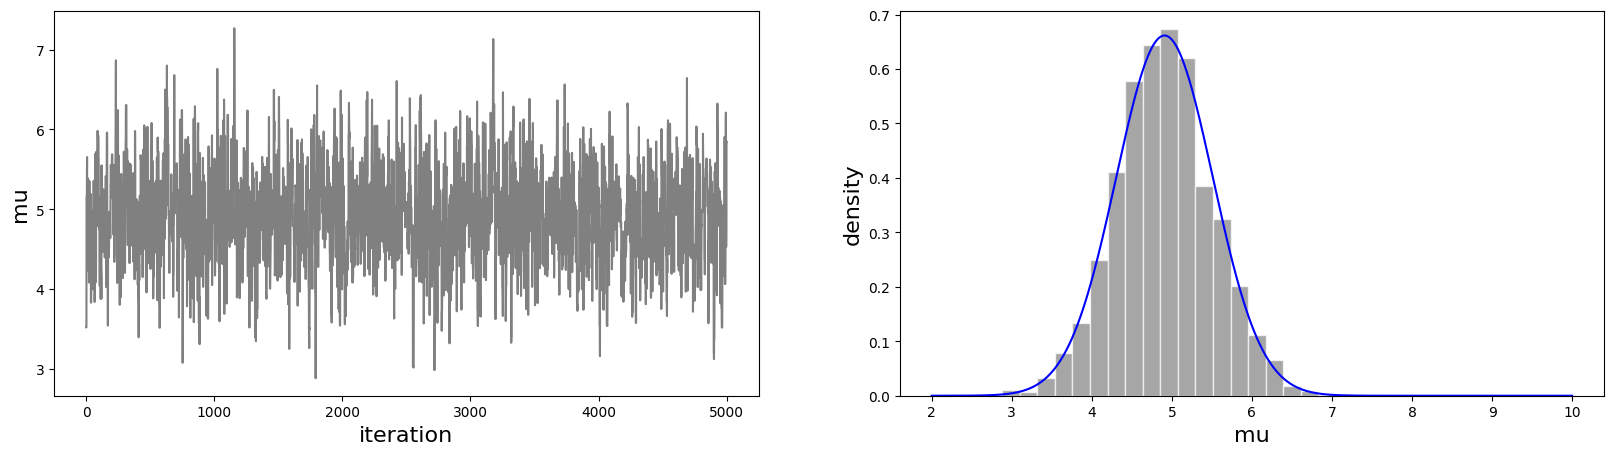

In [83]:
import matplotlib.pyplot as plt

#生成一行两列的画布
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

#trace plot：在第一列绘制出每一次的采样结果
axs[0].plot(mh_simulation["iteration"], mh_simulation["mu"],
            color="grey",)
axs[0].set_xlabel("iteration", fontsize=16)
axs[0].set_ylabel("mu", fontsize=16)

#density plot：在第二列绘制出采样结果的分布
axs[1].hist(mh_simulation["mu"], 
            edgecolor = "white",
            color="grey",
            alpha = 0.7,
            bins = 20,
            density = True)
axs[1].set_xlabel("mu", fontsize=16)
axs[1].set_ylabel("density", fontsize=16)

# 绘制分布外围线条
x_norm = np.linspace(2,10,10000)                  
y_norm = st.norm.pdf(x_norm, loc=mh_simulation["mu"].mean(), scale=mh_simulation["mu"].std())

axs[1].plot(x_norm, y_norm, color='blue')

我们可以使用 arviz 简化这个绘图的过程

C:\Users\Epool\AppData\Roaming\Python\Python39\site-packages\arviz\utils.py:184: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

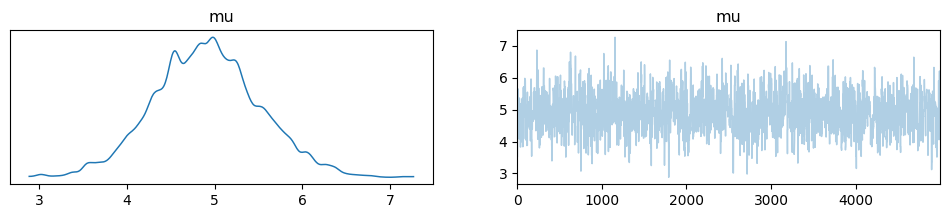

In [85]:
import arviz as az

az.plot_trace({"mu":mh_simulation["mu"]})

### 调试(Tuning)Metropolis-Hastings 算法

在建议分布 $\mu_{n+1} | \mu_{n} \; \sim \; \text{Normal}(\mu_{n}, \sigma)$中，$\sigma$反映了 建议选项的分布宽度，对$\sigma$ 的选择也会影响马尔科夫链的表现

🧐思考：我们仍然使用MH算法，尝试三种不同的$\sigma$
* $\sigma = 0.01$
* $\sigma = 1$
* $\sigma = 100$
    
请你判断以下的轨迹图和密度图分别对应上述哪种情况

![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch7-bad-idea-1.png)


可以结合以下代码进行判断

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as st
import pandas as pd

def one_mh_iteration(current, sigma = 1):

    """
    def后面为函数值，current为输入值，作为建议分布(正态分布)的均值
    
    接下来的代码和之前一样

    return 则是该函数返回的值，我们将建议值，接受概率，和下一个位置这三个值组成了一个数据框进行返回
    """
    proposal = st.norm(current, sigma).rvs()

    prior = st.norm(loc = 3, scale = 1)
    def likelihood(theta):
        # 假设数据 Y 为 6
        Y = 6
        return st.norm(loc = theta, scale = 0.75).pdf(Y)
        
    proposal_posterior = prior.pdf(proposal) * likelihood(proposal)
    current_posterior = prior.pdf(current) * likelihood(current)
    alpha = min(1,proposal_posterior/current_posterior)
    next_stop = np.random.choice([proposal, current], 1, p=[alpha,1-alpha])
    return pd.DataFrame({"proposal":[proposal],
                         "alpha":[alpha], 
                         "next_stop":[next_stop[0]]})

def mh_tour(N, sigma = 1):

    """
    N为迭代次数，w为均匀分布的一半宽度

    我们在单次采样函数的基础上叠加了一个循环
    将每次的采样结果存在mu[i]中，
    在每次采样结束后，将采样结果替换为当前位置

    返回值为迭代次数，和每次采样得到的结果
    """
    current = 3
    mu = np.zeros(N)

    for i in range(N):
        sim = one_mh_iteration(current,sigma)
        mu[i] = sim["next_stop"][0]
        current = sim["next_stop"][0]
    
    return pd.DataFrame({"iteration": range(1,N+1),
                         'mu': mu})

In [ ]:
#===========================================================================
#                            请修改 ... 中的值。
#===========================================================================
np.random.seed(84735)

mh_simulation = mh_tour(N=5000, sigma= ...)
az.plot_trace({"mu": mh_simulation["mu"]})

In [ ]:
#===========================================================================
#                            可以自行复制代码多试几次
#===========================================================================
mh_simulation = mh_tour(N=5000, sigma= ...)
az.plot_trace({"mu": mh_simulation["mu"]})

**总结**

* 当$w = 0.01$时：

    建议分布的范围很窄，比如$Normal(3, 0.001)$，这会导致下一个建议值和当前值非常接近，则$f(\mu')L(\mu'|y) \approx f(\mu)L(\mu|y)$
    $$
    \alpha = \min\left\lbrace 1, \; \frac{f(\mu')L(\mu'|y)}{f(\mu)L(\mu|y)} \right\rbrace \approx \min\left\lbrace 1, \; 1 \right\rbrace \; = 1 .
    $$
    那么我们很容易接受下一个采样值，但尽管马尔科夫链一直在转移，但探索的范围太窄了，我们可以看到采样一直在3附近

* 当$w = 100$时：

    类似的，我们可以推知此时建议分布的范围太宽了，超出了$\mu$可能的取值

    下一个建议值和当前值间隔太远，这会导致我们经常拒绝下一个采样值，多次停在当前位置。

**补充介绍：细致平衡 (detail Balance)**

我们已经感受到，从一个自定义的建议分布$q(x)$中采样，竟然可以得到关于参数的后验分布$p(x)$。

🤔这非常神奇，这到底是怎么做到的？

一切的关键在于，MCMC 的性质：细致平衡 (detail Balance)。
- 正如之前关于王者荣耀的例子一样，只要我们无限的进行游戏。我们选择英雄的概率分布就会固定。
- 这个概率分布代表了你玩游戏的喜好，或者是策略。也对应了参数的**后验分布**。
- 而我们在最开始玩游戏之前并不知道这个后验分布是什么形态的。
- 我们只是按照**转移矩阵**提供的概率进行英雄的选择。换句话说，我们知道自己选择英雄的策略(建议分布)，却不清楚选择英雄的分布(后验分布)。
- 此外，最后的后验分布也**与最开始的选择无关**。无论你最开始选择玩射手还是战士，最终你选择英雄的分布都是固定的 (😜也就是你可能更适合玩辅助)。

它的数学基础在于，当游戏无限进行时，状态转移的概率达到平衡，也就是所谓的细致平衡：

假设，状态转移矩阵为 P

| 选择的英雄 | 百里$\theta^{(n-1)}_{1}$ | 蔡文姬$\theta^{(n-1)}_{2}$ | 赵云$\theta^{(n-1)}_{3}$ | ... |
| :----: | :----: | :----: | :----: | :----: |
| 百里$\theta^{(n)}_{1}$ | 0.5 | 0.25 | 0.25 | ... |
| 蔡文姬$\theta^{(n)}_{2}$ | 0.5 | 0 | 0.5 | ... |
| 赵云$\theta^{(n)}_{3}$ | 0.25 | 0.25 | 0.5 | ... |
| ... | ... | ... | ... | ... |

假设每一局游戏有 10000个玩家在不同的对局中，那么这些玩家形成的英雄选择分布为 $\pi$

- 可以想象，一局游戏后这 10000个玩家可能可能更换英雄，也就是 $\pi * P$ (矩阵乘法)。
- 由于这 10000个玩家的选择策略或偏好不太可能瞬间变化，所以在总体上，他们的分布不换变化，也就是 $\pi * P = \pi$。
- 那么就会有 $\pi(i)* P(i,j) = \pi(j)* P(j,i)$。其中 i 代表上面矩阵的行，j代表矩阵的列。

其中，满足上述公式的 $\pi$ 就是参数的后验分布。
- 然而，我们一开始并不知道 $P$。
- 我们可以通过加入建议分布$q(x)$和拒绝率$\alpha$来替代 $P$。
- 得到： $\pi(i)* q(i,j) * \alpha(i,j) = \pi(j)* q(j, i) * \alpha(j, i)$

也就是，我们通过建议分布产生参数*拒绝率的方式来采样模拟了P。
- 一个不恰当的比喻：状态转移矩阵为 P 是你真实的你，但只有上帝知道你的本来面目 P。
- 然而，你能认识到当下你的样子 Q，并且在漫长人生中，你通过 $\alpha$ 拒绝那些不像你的 Q。
- 最后，你对当下自己的认识越来越接近上帝....


最后，我推荐 MCMC 讲解最好的视频(没有之一)：【蒙特卡洛（Monte Carlo, MCMC）方法的原理和应用】 https://www.bilibili.com/video/BV17D4y1o7J2/?share_source=copy_web&vd_source=4b5b4646c3f53f1b80954c381226c913

如果还是不懂 MCMC 原理，那放弃也行.....

不了解 MCMC 原理，并不影响对于它的使用。

### 7.8 Chapter summary

无论是在这些相对简单的单参数模型设置中，还是在更复杂的模型设置中，Metropolis-Hastings 算法都是通过两步之间的迭代，从后验中产生近似样本：
- 设定建议分布
- 根据建议分布的参数、未标准化后验计算接受率

本节课我们只考虑了一种 MCMC 算法，即 Metropolis-Hastings。这种算法虽然功能强大，但也有其局限性。
- 在以后的章节中，我们的贝叶斯模型将增加大量参数。调整 Metropolis-Hastings 算法以充分探索每个参数会变得很笨重。
- 然而，即使 Metropolis-Hastings 算法的实用性达到了极限，它仍然是一套更灵活的 MCMC 工具的基础，包括自适应 Metropolis-Hastings、Gibbs 和 Hamiltonian Monte Carlo (HMC) 算法。其中，HMC 是 pymc 默认使用的算法。